# 供水量预测
https://tensorflow.google.cn/tutorials/structured_data/time_series

In [1]:
import math
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Source Han Sans SC'

## 建立数据集

In [2]:
df = pd.DataFrame()
start_time = dt.datetime(2020, 5, 14)
end_time = dt.datetime(2020, 7, 6)
n = int((end_time - start_time).days)
for i in range(n):
    date = start_time + dt.timedelta(i)
    # 读入 csv
    file_name = "minute_water_supply/" + date.strftime("%Y-%m-%d") + '.csv'
    data = pd.read_csv(file_name)
    
    # 添加时间，精确到分钟
    data['日期'] = data['日期'].apply(lambda t: t[:-3])
    data['分钟时间'] = pd.to_datetime(data.pop('日期'), format='%Y-%m-%d %H:%M')
    # 分钟时间去重
    data.drop_duplicates(subset=['分钟时间'], keep='first', inplace=True)
    # 合计流量
    data['合计流量'] = data['浦庄管道1'] + data['浦庄管道2'] + data['红庄管道1']
    data.drop(data.columns[0:4], axis=1, inplace=True)
    # 使用时间作为 index
    data.set_index(['分钟时间'],inplace = True)
    # 合并到总df
    df = pd.concat([df, data])

In [3]:
# 插值缺失时间
rng = pd.date_range(dt.datetime(2020, 5, 14), periods=1440*n, freq='T')
df['合计流量'] = df['合计流量'].apply(lambda x: float('nan') if x < 5000 else x)
df = df.reindex(rng).interpolate()

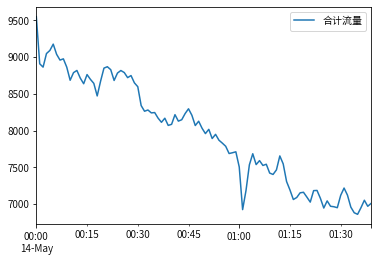

In [4]:
df[:100].plot()

### 添加天气假日

In [5]:
# 导入天气
weather = pd.read_csv("water_supply_with_rain.csv")
weather = weather.drop(columns=['昨日供水量'])

In [6]:
# 2019 放假安排 http://www.gov.cn/zhengce/content/2018-12/06/content_5346276.htm
# 2020 放假安排 http://www.gov.cn/zhengce/content/2019-11/21/content_5454164.htm
# 2020 延长春节 http://www.gov.cn/zhengce/content/2020-01/27/content_5472352.htm

# 2019 2020 节假日
hoilday =  {'20190101', '20190204', '20190205', '20190206', '20190207', '20190208', '20190209', '20190210',
            '20190405', '20190501', '20190607', '20190913', '20191001', '20191002', '20191003', '20191004',
            '20191005', '20191006', '20191007', 
            '20200101', '20200124', '20200125', '20200126', '20200127', '20200128', '20200129', '20200130',  
            '20200131', '20200201', '20200202', '20200404', '20200405', '20200406', '20200501', '20200502',
            '20200503', '20200504', '20200505', '20200625', '20200626', '20200627', '20201001', '20201002', 
            '20201003', '20201004', '20201005', '20201006', '20201007', '20201008'}

# 2019 2020 调休日
workday =  {'20190202', '20190203', '20190929', '20191012', '20200426', '20200509', '20200628', '20200927',
            '20201010'}

In [7]:
datetype_list = list()
for index, row in weather.iterrows():
    date = dt.datetime.strptime(row["日期"], "%Y/%m/%d")
    if date.weekday() in {0, 1, 2, 3, 4}:
        if date.strftime('%Y%m%d') in hoilday:
            datetype_list.append(1)
        else:
            datetype_list.append(0)
    if date.weekday() in {5, 6}:
        if date.strftime('%Y%m%d') in workday:
            datetype_list.append(0)
        else:
            datetype_list.append(1)

In [8]:
datetype = pd.DataFrame(datetype_list, columns=["日期类型"])
unite = pd.concat([weather, datetype], axis=1)
unite = unite[-n:]
unite = unite.drop(columns=['日期'])

In [9]:
# 重复行
newdf = pd.DataFrame(np.repeat(unite.values, 1440, axis=0))

In [10]:
df = df.reset_index()
df = pd.concat([df, newdf], axis=1)

In [11]:
# 重设列名
df.columns = ['分钟时间', '合计流量', '最低温', '最高温', '降水概率', '日期类型']

In [12]:
df

,分钟时间,合计流量,最低温,最高温,降水概率,日期类型
0,2020-05-14 00:00:00,9549.526855,19.8,26.4,0.7,0.0
1,2020-05-14 00:01:00,8908.245362,19.8,26.4,0.7,0.0
2,2020-05-14 00:02:00,8862.618896,19.8,26.4,0.7,0.0
3,2020-05-14 00:03:00,9047.261719,19.8,26.4,0.7,0.0
4,2020-05-14 00:04:00,9089.145142,19.8,26.4,0.7,0.0
...,...,...,...,...,...,...
76315,2020-07-05 23:55:00,9901.534423,22.9,24.6,0.7,1.0
76316,2020-07-05 23:56:00,9880.816894,22.9,24.6,0.7,1.0
76317,2020-07-05 23:57:00,9805.465088,22.9,24.6,0.7,1.0
76318,2020-07-05 23:58:00,9601.785767,22.9,24.6,0.7,1.0


In [13]:
# 按小时重新取样
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[::60].reset_index(drop=True)

In [14]:
df[:25]

,分钟时间,合计流量,最低温,最高温,降水概率,日期类型
0,2020-05-14 00:00:00,9549.526855,19.8,26.4,0.7,0.0
1,2020-05-14 01:00:00,7504.327271,19.8,26.4,0.7,0.0
2,2020-05-14 02:00:00,6786.833496,19.8,26.4,0.7,0.0
3,2020-05-14 03:00:00,7356.773926,19.8,26.4,0.7,0.0
4,2020-05-14 04:00:00,6612.100830,19.8,26.4,0.7,0.0
5,2020-05-14 05:00:00,8603.869141,19.8,26.4,0.7,0.0
6,2020-05-14 06:00:00,12610.588379,19.8,26.4,0.7,0.0
7,2020-05-14 07:00:00,17475.954102,19.8,26.4,0.7,0.0
8,2020-05-14 08:00:00,17979.176758,19.8,26.4,0.7,0.0
9,2020-05-14 09:00:00,17835.211914,19.8,26.4,0.7,0.0


### 特征工程

In [15]:
date_time = pd.to_datetime(df.pop('分钟时间'), format='%Y/%m/%d')

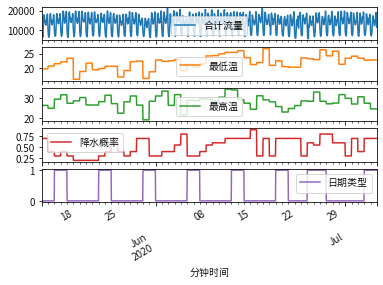

In [16]:
plot_cols = ['合计流量', '最低温', '最高温', '降水概率', '日期类型']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

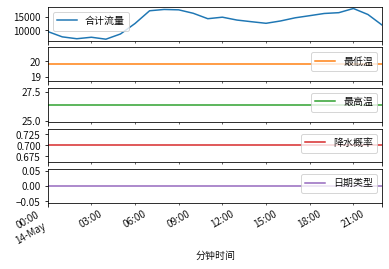

In [17]:
plot_features = df[plot_cols][:24]
plot_features.index = date_time[:24]
_ = plot_features.plot(subplots=True)

In [18]:
timestamp_s = date_time.map(dt.datetime.timestamp)
day = 24*60*60
year = (365.2425)*day

df['日正弦'] = np.sin(timestamp_s * (2 * np.pi / day))
df['日余弦'] = np.cos(timestamp_s * (2 * np.pi / day))

Text(0.5, 1.0, 'Time of day signal')

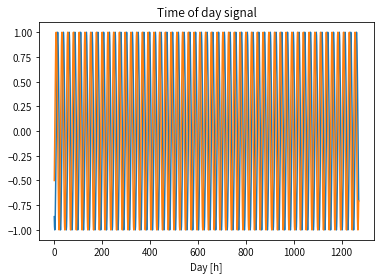

In [19]:
plt.plot(np.array(df['日正弦']))
plt.plot(np.array(df['日余弦']))
plt.xlabel('Day [h]')
plt.title('Time of day signal')

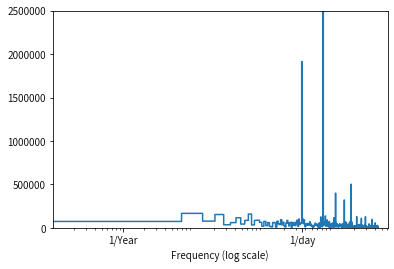

In [20]:
fft = tf.signal.rfft(df['合计流量'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['合计流量'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 0.25e7)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### 保存数据

In [21]:
df.to_csv('cleaned_data.csv')

### 分割数据

In [22]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### 规范化数据

In [23]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

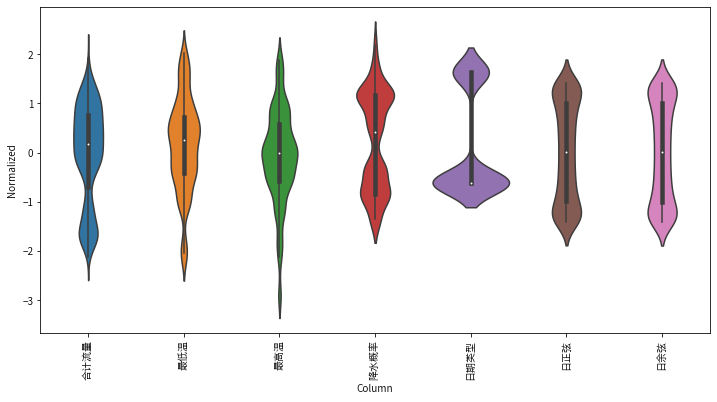

In [24]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## 数据窗口

### 索引和偏移

In [25]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

 

In [26]:
w1 = WindowGenerator(input_width=5, label_width=1, shift=1,
                     label_columns=['合计流量'])

In [27]:
w1

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['合计流量']

In [28]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [29]:
 # Stack three slices, the length of the total window: batch_size = 3
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')
 

All shapes are: (batch, time, features)
Window shape: (3, 6, 7)
Inputs shape: (3, 5, 7)
labels shape: (3, 1, 1)


In [30]:
example_inputs

<tf.Tensor: shape=(3, 5, 7), dtype=float64, numpy=
array([[[-1.12854949e+00, -7.30877291e-01, -6.49176685e-01,
          1.17597288e+00, -6.10767694e-01, -1.22021637e+00,
         -7.06046893e-01],
        [-1.65794149e+00, -7.30877291e-01, -6.49176685e-01,
          1.17597288e+00, -6.10767694e-01, -1.36130987e+00,
         -3.64895029e-01],
        [-1.84366198e+00, -7.30877291e-01, -6.49176685e-01,
          1.17597288e+00, -6.10767694e-01, -1.40943423e+00,
          1.20601566e-03],
        [-1.69613510e+00, -7.30877291e-01, -6.49176685e-01,
          1.17597288e+00, -6.10767694e-01, -1.36130987e+00,
          3.67307061e-01],
        [-1.88889085e+00, -7.30877291e-01, -6.49176685e-01,
          1.17597288e+00, -6.10767694e-01, -1.22021637e+00,
          7.08458924e-01]],

       [[-1.91206390e+00,  7.30256099e-01, -3.12910032e-01,
         -8.52352435e-01, -6.10767694e-01, -1.22021637e+00,
          7.08458924e-01],
        [-1.22208622e+00,  7.30256099e-01, -3.12910032e-01,
     

In [31]:
example_labels

<tf.Tensor: shape=(3, 1, 1), dtype=float64, numpy=
array([[[-1.37332933]],

       [[ 1.36551537]],

       [[ 0.03903765]]])>

### 绘图

In [32]:
def make_dataset(self, data, shuffle=True, batch_size=32):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=shuffle,
      batch_size=batch_size,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [33]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
 

In [34]:
def plot(self, model=None, plot_col='合计流量', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot
 

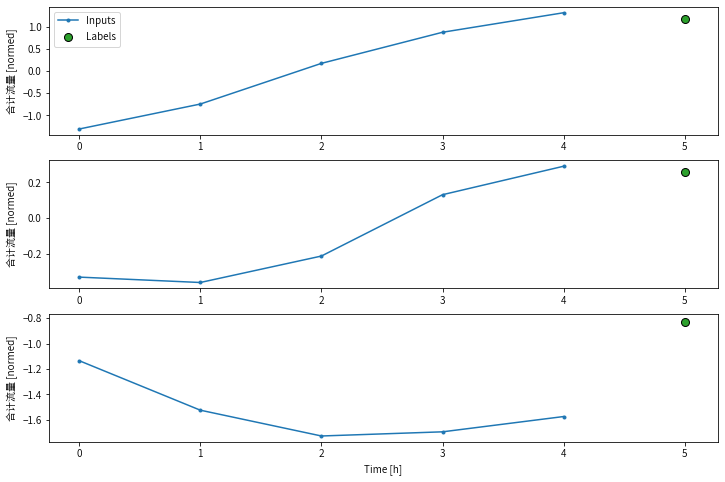

In [35]:
w1.plot()

## 单步模型

In [36]:
wide_window = WindowGenerator(input_width=5, label_width=1, shift=1,
                     label_columns=['合计流量'])
wide_window 

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['合计流量']

In [37]:
# Each element is an (inputs, label) pair
wide_window.train.element_spec

(TensorSpec(shape=(None, 5, 7), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [38]:
for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 5, 7)
Labels shape (batch, time, features): (32, 1, 1)


### 基准线

In [39]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['合计流量'])
single_step_window
 

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['合计流量']

In [40]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [41]:
baseline = Baseline(label_index=column_indices['合计流量'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)
 

8/8 [==============================] - 0s 1ms/step - loss: 0.2648 - mean_absolute_error: 0.3757


### LSTM

In [42]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1])
])
 

In [43]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)
 

Input shape: (32, 5, 7)
Output shape: (32, 1, 1)


In [44]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history
 

In [45]:
history = compile_and_fit(lstm_model, wide_window)

# IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
 

Epoch 1/20
28/28 [==============================] - 1s 18ms/step - loss: 0.8226 - mean_absolute_error: 0.7385 - val_loss: 0.6217 - val_mean_absolute_error: 0.6660
Epoch 2/20
28/28 [==============================] - 0s 7ms/step - loss: 0.5300 - mean_absolute_error: 0.6099 - val_loss: 0.4166 - val_mean_absolute_error: 0.5551
Epoch 3/20
28/28 [==============================] - 0s 7ms/step - loss: 0.3538 - mean_absolute_error: 0.4986 - val_loss: 0.2724 - val_mean_absolute_error: 0.4310
Epoch 4/20
28/28 [==============================] - 0s 6ms/step - loss: 0.2296 - mean_absolute_error: 0.3864 - val_loss: 0.1824 - val_mean_absolute_error: 0.3431
Epoch 5/20
28/28 [==============================] - 0s 6ms/step - loss: 0.1551 - mean_absolute_error: 0.3137 - val_loss: 0.1370 - val_mean_absolute_error: 0.2947
Epoch 6/20
28/28 [==============================] - 0s 7ms/step - loss: 0.1107 - mean_absolute_error: 0.2608 - val_loss: 0.1116 - val_mean_absolute_error: 0.2620
Epoch 7/20
28/28 [=========

In [46]:
print(val_performance)
print(performance)

{'Baseline': [0.26478439569473267, 0.3757437765598297], 'LSTM': [0.060528382658958435, 0.1747061163187027]}
{'Baseline': [0.2810479402542114, 0.39017853140830994], 'LSTM': [0.026752427220344543, 0.11991209536790848]}


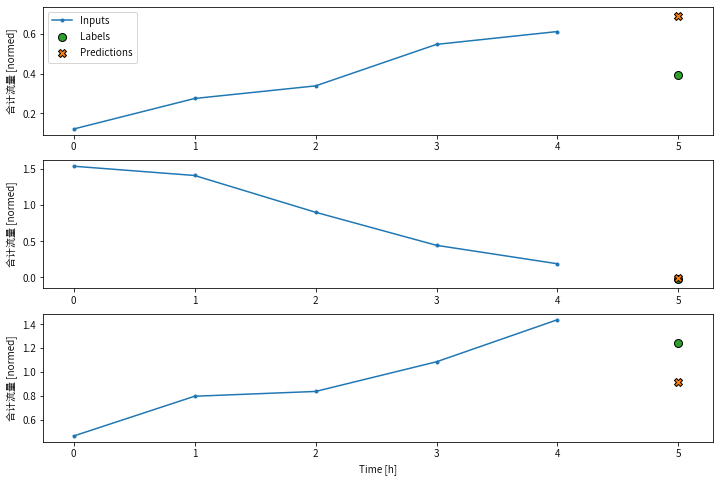

In [47]:
wide_window.plot(lstm_model)

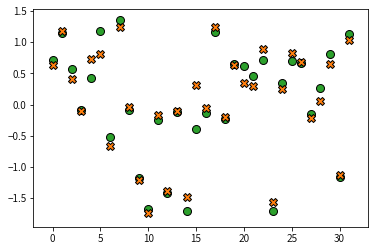

In [48]:
inputs, labels = next(iter(wide_window.test))
pred = lstm_model(inputs)

plt.scatter(range(len(labels)), labels,
            edgecolors='k', label='Labels', c='#2ca02c', s=64)
            
plt.scatter(range(len(pred)), pred,
                marker='X', edgecolors='k', label='Predictions',
                c='#ff7f0e', s=64)

## 多步骤模型

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

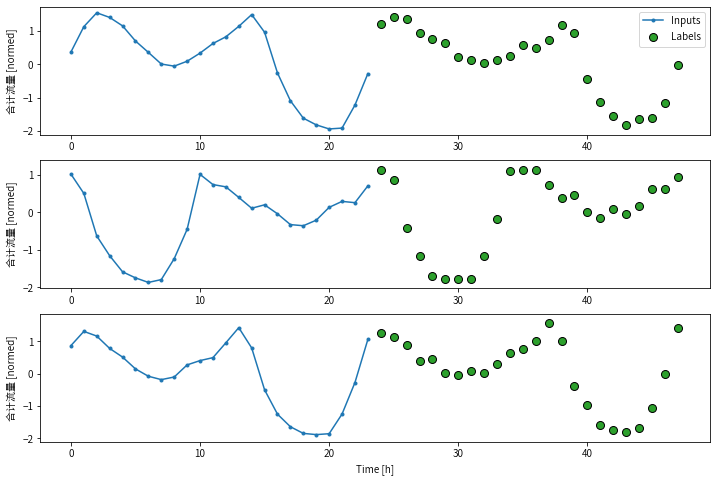

In [49]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [50]:
multi_window.train.element_spec

(TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 24, 7), dtype=tf.float32, name=None))

### Baseline

In [51]:
multi_val_performance = {}
multi_performance = {}

7/7 [==============================] - 0s 959us/step - loss: 0.6042 - mean_absolute_error: 0.4313


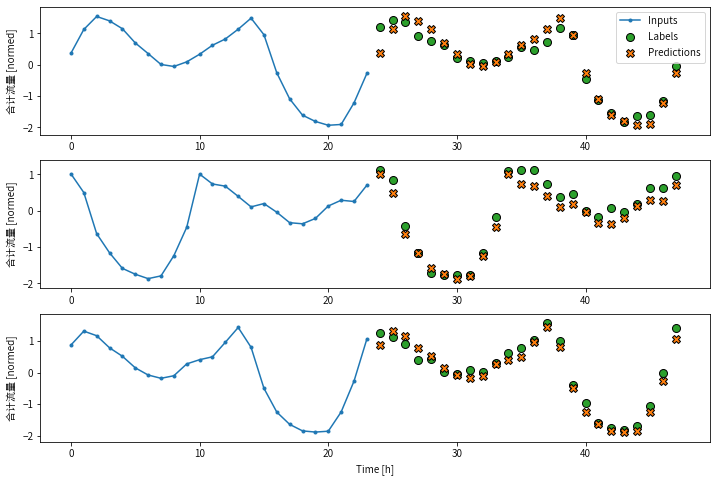

In [52]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)
 

### 自回归模型

In [53]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [54]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [55]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [56]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)
  
  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [57]:
print('Input shape (batch, time, features: ', multi_window.example[0].shape)
print('Output shape (batch, time, features: ', multi_window.example[1].shape)
print('Predict shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Input shape (batch, time, features:  (32, 24, 7)
Output shape (batch, time, features:  (32, 24, 7)
Predict shape (batch, time, features):  (32, 24, 7)


In [58]:
history = compile_and_fit(feedback_model, multi_window)

Epoch 1/20
27/27 [==============================] - 1s 39ms/step - loss: 0.9353 - mean_absolute_error: 0.8142 - val_loss: 0.9141 - val_mean_absolute_error: 0.8056
Epoch 2/20
27/27 [==============================] - 0s 15ms/step - loss: 0.7709 - mean_absolute_error: 0.7226 - val_loss: 0.8416 - val_mean_absolute_error: 0.7774
Epoch 3/20
27/27 [==============================] - 0s 15ms/step - loss: 0.6713 - mean_absolute_error: 0.6659 - val_loss: 0.7924 - val_mean_absolute_error: 0.7416
Epoch 4/20
27/27 [==============================] - 0s 11ms/step - loss: 0.5127 - mean_absolute_error: 0.5579 - val_loss: 0.6255 - val_mean_absolute_error: 0.6082
Epoch 5/20
27/27 [==============================] - 0s 11ms/step - loss: 0.3930 - mean_absolute_error: 0.4657 - val_loss: 0.6138 - val_mean_absolute_error: 0.5822
Epoch 6/20
27/27 [==============================] - 0s 11ms/step - loss: 0.3450 - mean_absolute_error: 0.4272 - val_loss: 0.5949 - val_mean_absolute_error: 0.5716
Epoch 7/20
27/27 [====

7/7 [==============================] - 0s 4ms/step - loss: 0.6303 - mean_absolute_error: 0.5571


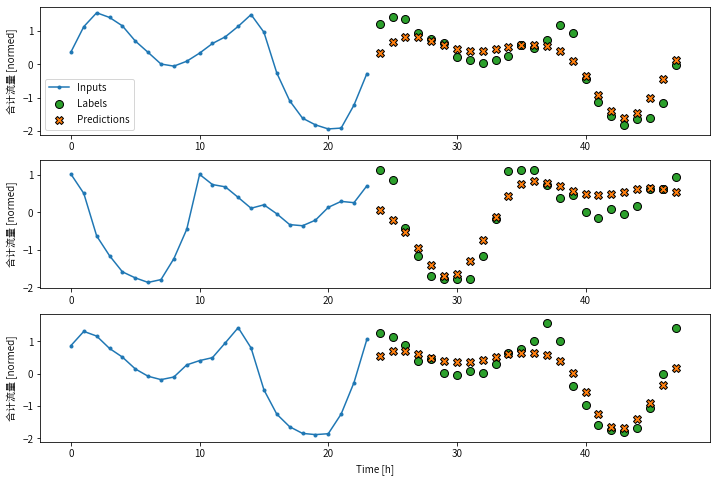

In [59]:
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

In [60]:
print(multi_val_performance)
print(multi_performance)

{'Repeat': [0.6042114496231079, 0.43132179975509644], 'AR LSTM': [0.6303292512893677, 0.5571213960647583]}
{'Repeat': [0.7155351638793945, 0.5029775500297546], 'AR LSTM': [0.47794970870018005, 0.45493221282958984]}


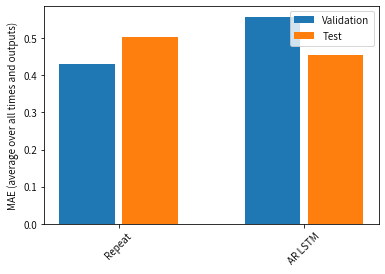

In [61]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = feedback_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()